9

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
data=pd.read_csv('dataset_petandcovid.csv')
data = data.drop(columns=['self-reported level of stress','quality of life (EQ-5D-5L score converted on the scale developed for Canada)','emotional, psychological or mental health condition','social support', 'region','ethnicity','tested positive to COVID-19 (or household member)','change in mental health since the beginning of the pandemic','anxiety','perceived mental health','change in income since the beginning of the pandemic'])
data = data[data['yearly income'] != 'Prefer not to answer']
#replace education level
replacement= {
    'Before high school': 1,
    'High school': 2,
    'College': 3,
    'University': 4}
data['highest level of education']=data['highest level of education'].replace(replacement)
#replace no with 0, yes with 1
replacement_bool = {'No':0,'Yes':1}
data = data.replace(replacement_bool)
#change in ownership
replacement_change = {'Loss':-1, 'New':1}
data = data.replace(replacement_change)
#replace men with 1, women with 2, not to say 0.5
replacement_gender = {'Men':0,'Women':1,'Other or did not answer':0.5}
data = data.replace(replacement_gender)
#replace the income with it max(min num using the upperbound, max num using the lower bound)
replacement_income = {'$19,999 or less':19999,'$20,000-$39,999':39999,'$40,000-$59,000':59000,'$60,000-$79,999':79999,'$80,000-$99,999':99999,'$100,000-$119,999':119999,'$120,000 or more':120000
}
data = data.replace(replacement_income)
#replace extent with num
replacement_stress = {'Not at all':1,'Not very':2,'A bit':3,'Quite a bit':4,'Extremely':5}
data = data.replace(replacement_stress)

#replace age with the average of the range
#'18-24' '45-54' '35-44' '55-64' '65' '25-34'
replacement_age={'18-24':(18+24)/2,'25-34':(25+34)/2,'35-44':(35+44)/2,'45-54':(45+54)/2,'55-64':(55+64)/2,'65':65}
data = data.replace(replacement_age)

average_area = {
    'Nova Scotia': 62.23697583, 'Alberta': 56.31412163, 'Newfoundland and Labrador': 65.05738259, 'Ontario': 58.57044704,
    'British Columbia': 67.21969444, 'New Brunswick': 67.87778935, 'Saskatchewan': 43.71630478, 'Québec': 51.14337591, 'Manitoba': 44.5624268,
    'Prince Edward Island': 62.5, 'Yukon': 64.3, 'Northwest Territories': 62.3, 'Nunavut': 57.5
}

incomeRelation = {
    19999: 0.9, 39999: 0.95, 59000: 1, 79999: 1.05, 99999: 1.1, 119999: 1.15, 120000: 1.2
}
data['living ratio'] = data['yearly income']
data['living ratio']=data['living ratio'].replace(incomeRelation)
data['regionLivingArea'] = data['province or territory']
data['regionLivingArea']=data['regionLivingArea'].replace(average_area)

noise = np.random.normal(0, 0.0001, size=len(data))
data['Living area/p'] = round(data['living ratio']*data['regionLivingArea'])
data['Living area/p'] = data['Living area/p'] + np.mean(data['Living area/p'])*noise
#不过敏=1 过敏=0
data['allergy'] = data['pet ownership'].apply(lambda x: 1 if x == 1 else (0 if np.random.rand() < 0.2 else 1))

# Adjusting the income per head calculation
data['income/head'] = data['yearly income'] / data['number of people in the household']

data = data.drop(columns=['living ratio','regionLivingArea'])

data['Elders/Kid'] = data['number of people in the household'].apply(
    lambda x: 1 if x > 2 and np.random.rand() < 0.85 else (0 if np.random.rand() < 0.9 else 1)
)
data['pet experience'] = data.apply(lambda row: 1 if row['pet ownership'] == 0 and row['change in pet ownership'] == -1 else (1 if row['pet ownership'] == 1 and row['change in pet ownership'] == 0 else 0), axis=1)

features = ['pet ownership','allergy','number of people in the household','Living area/p',
            'income/head','pet attitude','pet experience','Elders/Kid',
            'self-assessed overall health','highest level of education']
dataUse = data[features]

In [123]:
dataUse.head()

,pet ownership,allergy,number of people in the household,Living area/p,income/head,pet attitude,pet experience,Elders/Kid,self-assessed overall health,highest level of education
0,0,1,4,56.009322,4999.75,72,0,1,80,2
1,0,0,4,68.011032,30000.00,69,0,1,80,3
2,0,1,2,65.003286,29500.00,74,0,0,41,4
3,1,1,5,69.996875,24000.00,116,1,1,80,2
4,1,1,2,60.998087,39999.50,99,1,0,78,4


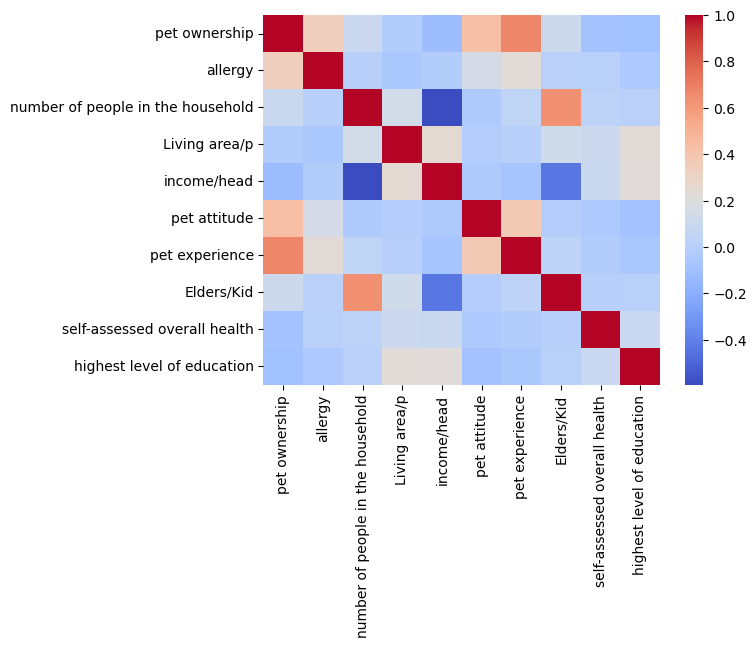

In [124]:
import seaborn as sns
matrix = dataUse.corr()
#print(matrix)
# Create a heatmap
sns.heatmap(matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

In [130]:
#weights = [0.14587631, 0.12698408, 0.07851146, 0.04440458, 0.04481399, 0.10019337,
# 0.13491072, 0.25410177, 0.07020372] #pet attitude	Age	disability	loneliness	gender	highest level of education	income/head	allergy	Living area

weights = {'allergy':0.26884598, 'number of people in the household':0.06366679, 'Living area/p':0.09101158,'income/head':0.1006127,'pet attitude':0.19073045,'pet experience': 0.09242143,
 'Elders/Kid':0.08347651,'self-assessed overall health':0.04871114,'highest level of education':0.06052343}
feature_data = data[features]

In [131]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_data = pd.DataFrame(scaler.fit_transform(feature_data), columns=feature_data.columns)

In [132]:
feature_data['score'] = feature_data['allergy']*weights['allergy']+feature_data['number of people in the household']*weights['number of people in the household']+feature_data['Living area/p']*weights['Living area/p']+feature_data['income/head']*weights['income/head']+feature_data['pet attitude']*weights['pet attitude']+feature_data['pet experience']*weights['pet experience']+feature_data['Elders/Kid']*weights['Elders/Kid']+feature_data['self-assessed overall health']*weights['self-assessed overall health']+feature_data['highest level of education']*weights['highest level of education']

In [133]:
feature_data.head()

,pet ownership,allergy,number of people in the household,Living area/p,income/head,pet attitude,pet experience,Elders/Kid,self-assessed overall health,highest level of education,score
0,0.0,1.0,0.230769,0.404802,0.018292,0.495327,0.0,1.0,0.80,0.333333,0.559314
1,0.0,0.0,0.230769,0.690475,0.231708,0.467290,0.0,1.0,0.80,0.666667,0.352767
2,0.0,1.0,0.076923,0.618882,0.227440,0.514019,0.0,0.0,0.41,1.000000,0.531486
3,1.0,1.0,0.307692,0.737743,0.180489,0.906542,1.0,1.0,0.80,0.333333,0.781685
4,1.0,1.0,0.076923,0.523548,0.317070,0.747664,1.0,0.0,0.78,1.000000,0.686835


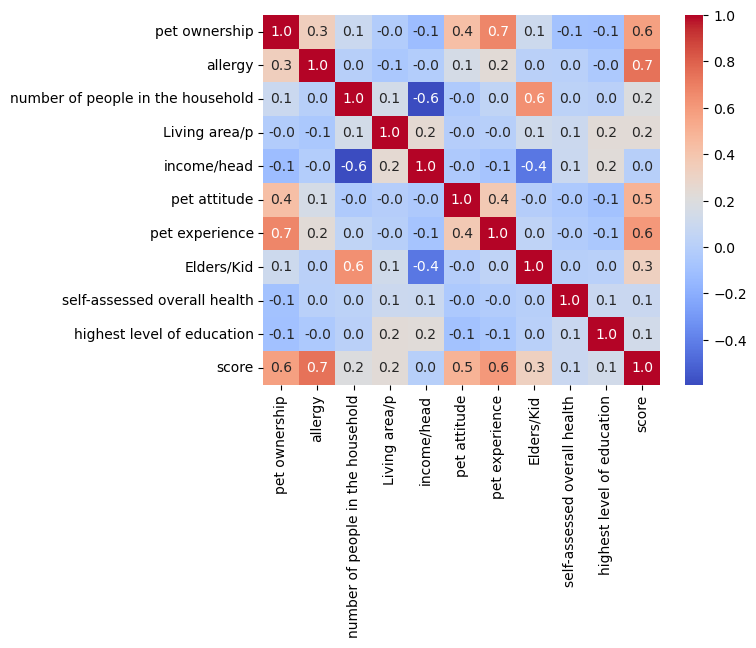

In [134]:
matrix = feature_data.corr()
# Create a heatmap
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.show()

In [139]:
from sklearn import tree
from sklearn.model_selection import train_test_split
clf = tree.DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(feature_data.drop(columns = ['score','pet ownership']),feature_data[['pet ownership']],test_size=0.2, random_state=42)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.7843866171003717

In [145]:
result = tree.export_text(clf)
print(result)
# Save rules
with open("decistion_tree.log", "w") as fout:
    fout.write(result)

|--- feature_5 <= 0.50
|   |--- feature_4 <= 0.88
|   |   |--- feature_0 <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- feature_0 >  0.50
|   |   |   |--- feature_4 <= 0.71
|   |   |   |   |--- feature_7 <= 0.69
|   |   |   |   |   |--- feature_4 <= 0.41
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_4 >  0.41
|   |   |   |   |   |   |--- feature_7 <= 0.66
|   |   |   |   |   |   |   |--- feature_2 <= 0.54
|   |   |   |   |   |   |   |   |--- feature_4 <= 0.63
|   |   |   |   |   |   |   |   |   |--- feature_4 <= 0.49
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- feature_4 >  0.49
|   |   |   |   |   |   |   |   |   |   |--- feature_4 <= 0.57
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- feature_4 >  0.57
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- feature_4 >  0.63
|   |   |   |  

In [64]:
feature_data['readiness'] = feature_data['score'].apply(lambda x: 0 if x<0.5 else 1)

In [65]:
feature_data.head()

,pet ownership,pet attitude,age,disability,loneliness,gender,highest level of education,income/head,allergy,Living area,score,readiness
0,0.0,0.495327,0.000000,0.0,0.833333,0.0,0.333333,0.018292,1.0,0.189592,0.412538,0
1,0.0,0.467290,0.647727,0.0,0.333333,0.0,0.666667,0.231708,1.0,0.237498,0.534050,1
2,0.0,0.514019,0.647727,1.0,0.333333,0.0,1.000000,0.227440,1.0,0.091715,0.641965,1
3,1.0,0.906542,0.647727,0.0,0.500000,0.0,0.333333,0.180489,1.0,0.321898,0.571144,1
4,1.0,0.747664,0.000000,0.0,0.166667,1.0,1.000000,0.317070,1.0,0.084386,0.564277,1


In [146]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(feature_data['pet ownership'],feature_data['readiness'])
print(accuracy)

KeyError: 'readiness'

AttributeError: 'DataFrame' object has no attribute 'unique'